<a href="https://colab.research.google.com/github/pritesh2292/Netflix-Movies-Tv-Shows-Clustering/blob/main/Netflix_unsupervised_ML_capstone_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Liabraries

In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns #importing our visualization library
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib.cm as cm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as sch

import warnings
warnings.filterwarnings('ignore')

#Dataset Loading

In [2]:
# Load Dataset
# mount the drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading Data

In [4]:
# read the data
path = "/content/drive/MyDrive/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"
df = pd.read_csv(path)

#Dataset first look

In [5]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#checking for null values

In [6]:
 df.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

#Heatmap 

<Axes: >

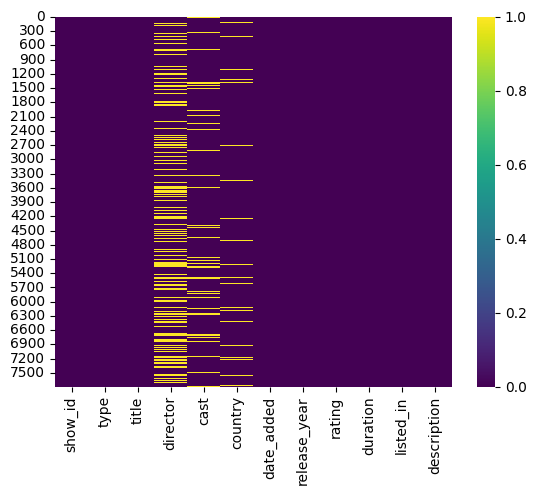

In [7]:
sns.heatmap(df.isnull(),cmap = 'viridis')

We have null values in director, cast,country,date_added and rating.So lets deal with it.

In [8]:
df['rating'].value_counts().unique()

array([2863, 1931,  806,  665,  386,  280,  271,  247,  194,   84,   39,
          6,    5,    3])

In the above data, we can choose to drop the director and cast columns completely as they are not a huge part for us while we visualize the data and they dont add any significant value to our analysis. We are only focused on visualizing this data hence dropping two columns wont be any trouble for us.But this should not be a regular practise as if we are making a recommender system, we cannot drop the director and cast of a movie as these are a key feature used to recommend movies to users



In [9]:
df.drop(['director','cast'],axis = 1,inplace = True)

In [10]:
df.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


We replaced all the Nan values in the country column with United States as Netflix was created in the USA and every show is aired on Netflix US. So instead of dropping the whole column we just replaced the values in it in order to save our data.

In [11]:
df['country'].replace(np.nan, 'United States',inplace  = True)

We already have released year for each movie and hence even if we dont have released date,it wont affect our analsis much. Hence we can Drop released date column.

In [12]:
df.drop(['date_added'],axis =1,inplace = True)

In [13]:
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [14]:
df['rating'].value_counts()

TV-MA       2863
TV-14       1931
TV-PG        806
R            665
PG-13        386
TV-Y         280
TV-Y7        271
PG           247
TV-G         194
NR            84
G             39
TV-Y7-FV       6
UR             5
NC-17          3
Name: rating, dtype: int64

In [15]:
df['listed_in'].value_counts()

Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
Stand-Up Comedy & Talk Shows, TV Mysteries, TV Sci-Fi & Fantasy                      1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: listed_in, Length: 492, dtype: int64

As we can see we only have 10 missing values in our rating column, we can either drop them or replace them. We have TV-MA which is the most common raing and hence we can replace all these nan values with TV-MA.

In [18]:
df['rating'].replace(np.nan, 'TV-MA',inplace  = True)

In [19]:
df.isnull().sum()

show_id         0
type            0
title           0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

We have now dealt with all of our missing data so lets get started with our data visualization

In [20]:
df.head()

,show_id,type,title,country,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#Data Visualization

<Axes: xlabel='type', ylabel='count'>

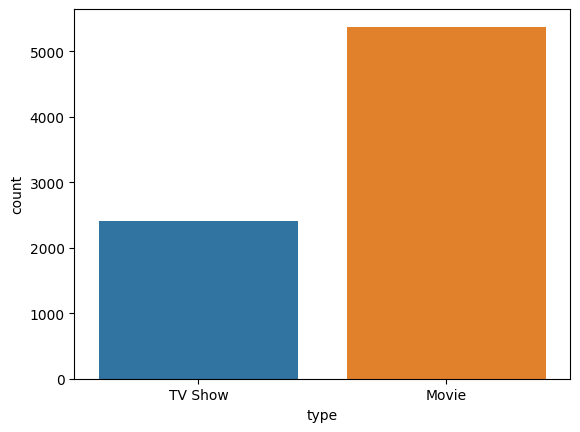

In [21]:
sns.countplot(x='type',data = df) #looking at number of Movies and TV shows

<Axes: xlabel='rating', ylabel='count'>

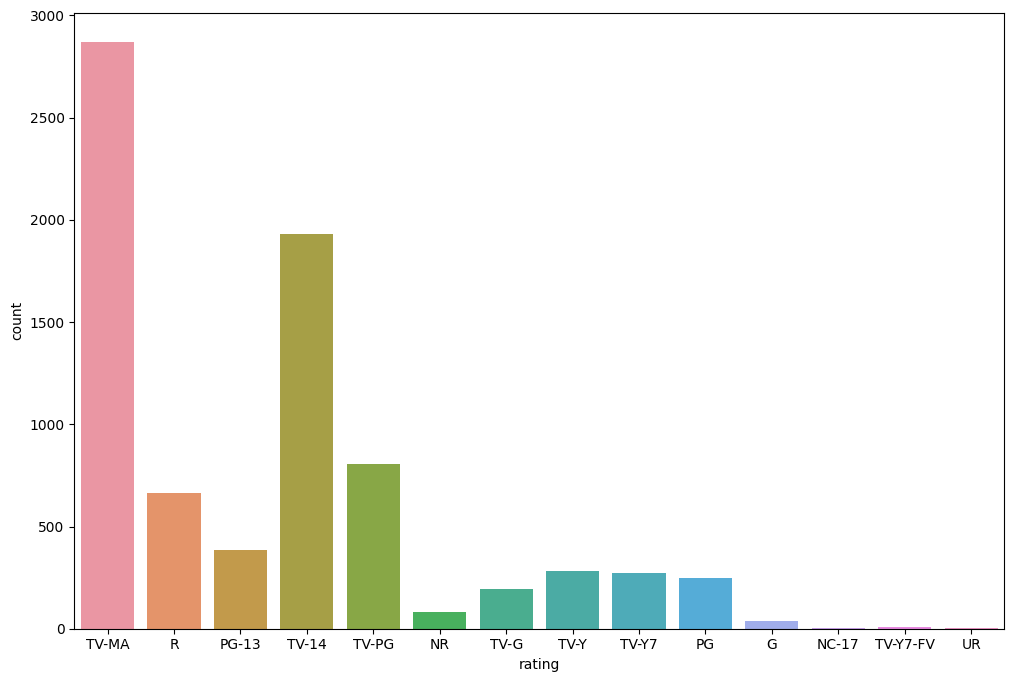

In [22]:
plt.figure(figsize = (12,8))
sns.countplot(x='rating',data = df)

<Axes: xlabel='release_year', ylabel='count'>

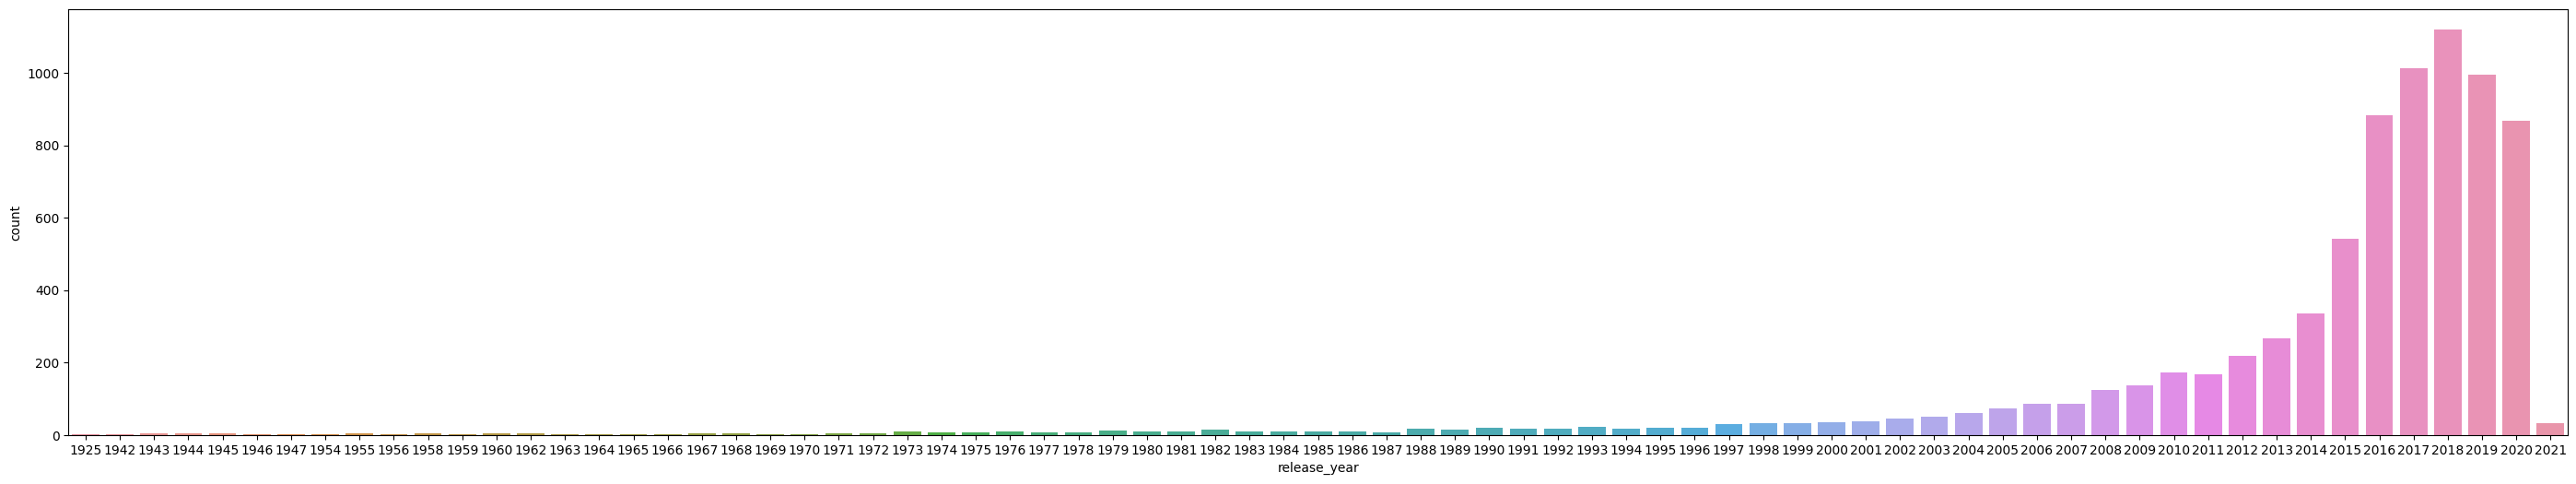

In [23]:
plt.figure(figsize = (35,6))
sns.countplot(x='release_year',data = df)

As we can see most of the Movies and Tv shows on Netflix are Released in the past decade and very few were released earlier

<Axes: xlabel='rating', ylabel='type'>

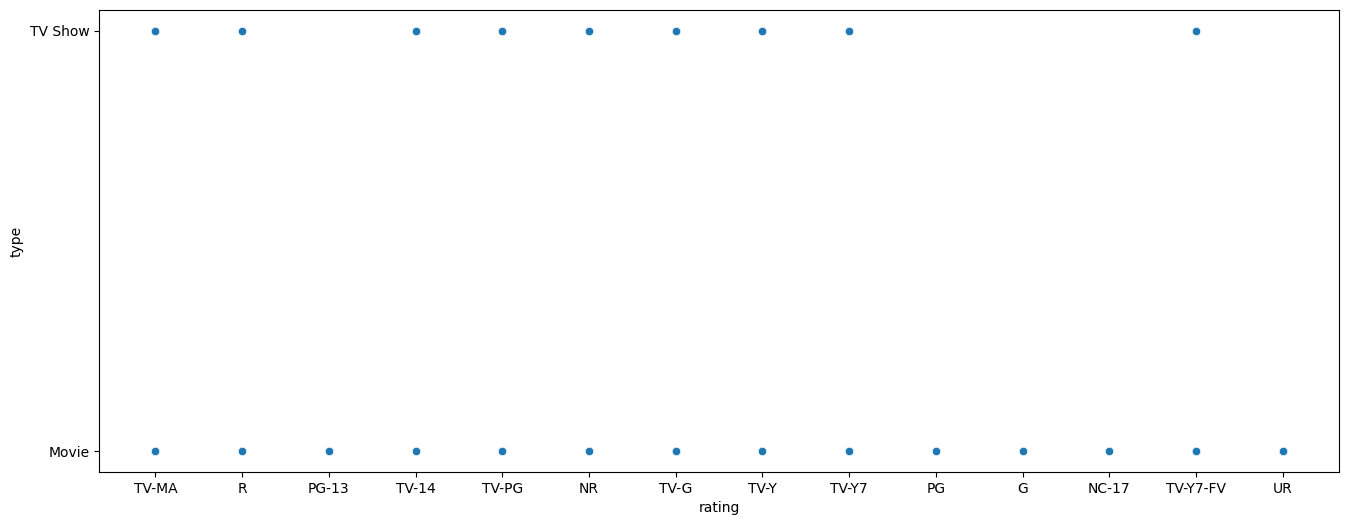

In [24]:
plt.figure(figsize=(16,6))
sns.scatterplot(x='rating',y='type',data = df) #analysing the type, whether its a movie or a movie v/s the rating it has

<Axes: xlabel='rating', ylabel='count'>

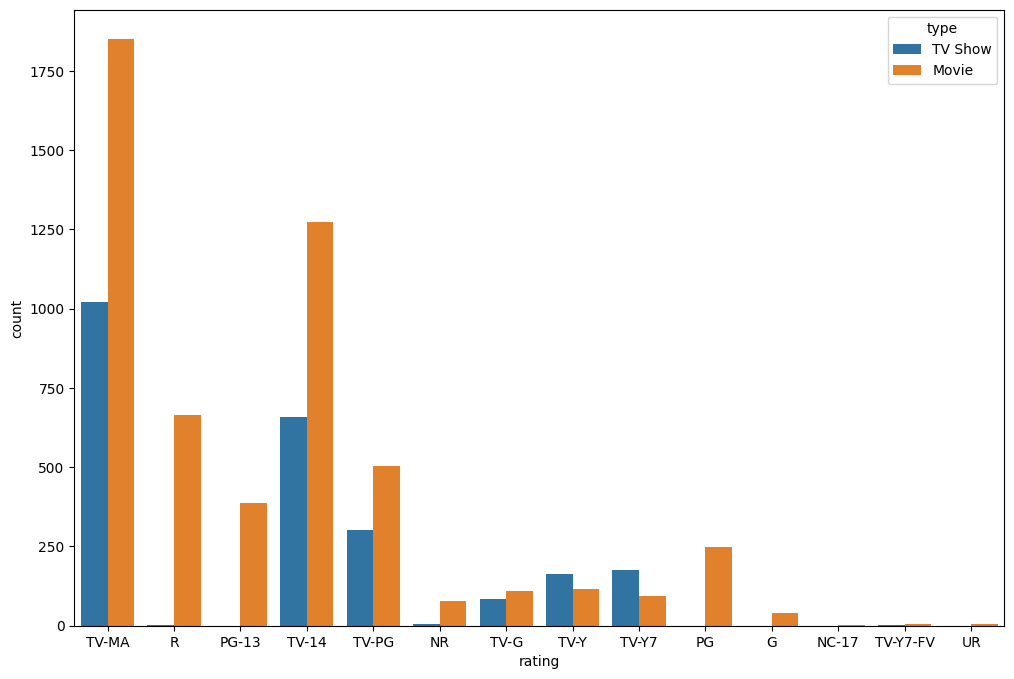

In [25]:
plt.figure(figsize = (12,8))
sns.countplot(x='rating',data = df,hue='type')

#Pie-chart for the Type: Movie and TV Shows

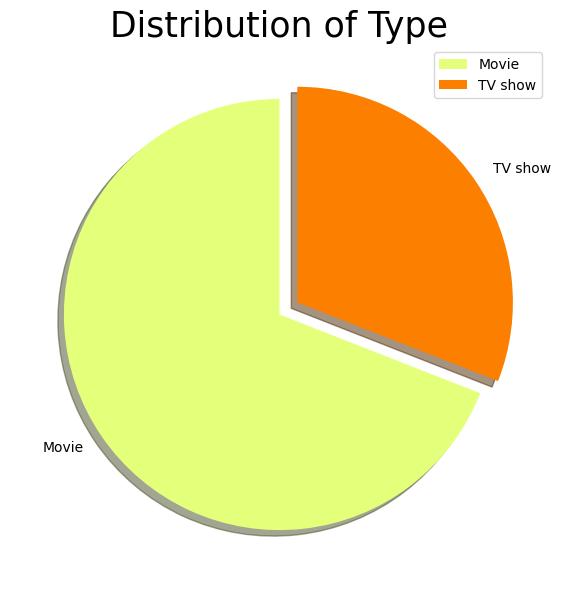

In [56]:
labels = ['Movie', 'TV show']
size = df['type'].value_counts()
colors = plt.cm.Wistia(np.linspace(0, 1, 2))
explode = [0, 0.1]
plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size,labels=labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Distribution of Type', fontsize = 25)
plt.legend()
plt.show()

In [27]:
import plotly.express as px #distribution according to countries
top_rated=df[0:10]
fig =px.sunburst(top_rated,path=['country'])
fig.show()

# pie-chart for rating

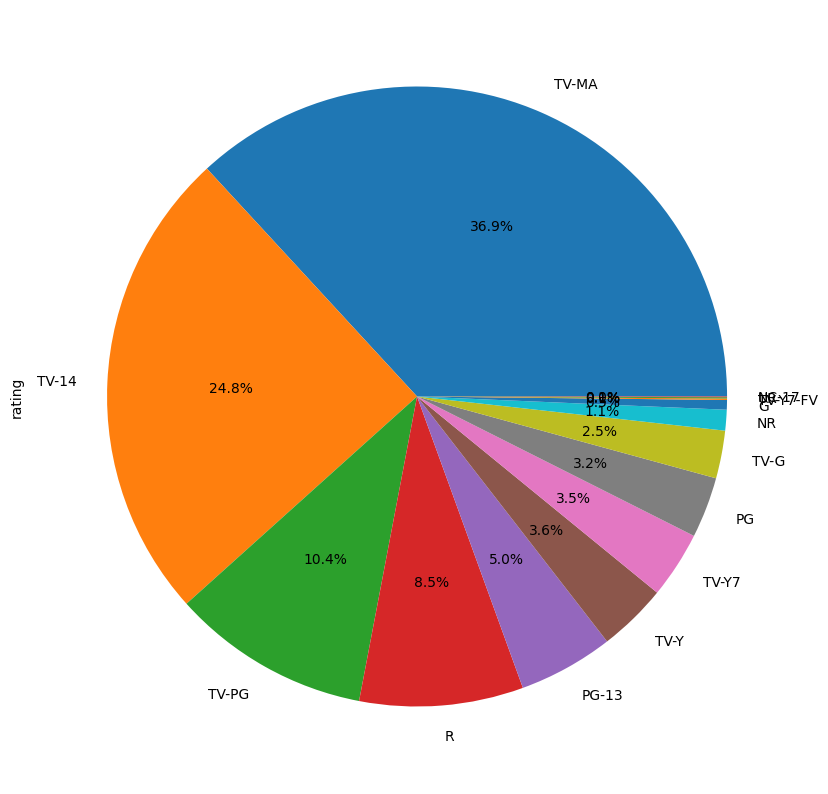

In [32]:
df['rating'].value_counts().plot.pie(autopct='%1.1f%%',figsize=(10,20)) #distribution according to the rating
plt.show()

In [33]:
old = df.sort_values("release_year", ascending = True) #oldest movies available on netflix
old = old[old['duration'] != ""]
old[['title', "release_year"]][:15]

,title,release_year
4867,Pioneers: First Women Filmmakers*,1925
6117,The Battle of Midway,1942
4960,Prelude to War,1942
7679,WWII: Report from the Aleutians,1943
7342,Undercover: How to Operate Behind Enemy Lines,1943
7616,Why We Fight: The Battle of Russia,1943
7268,Tunisian Victory,1944
6699,The Negro Soldier,1944
6657,The Memphis Belle: A Story of a\nFlying Fortress,1944
5371,San Pietro,1945


In [34]:
tag = "Stand-Up Comedy" #standup shows on Netflix
df["relevant"] = df['listed_in'].fillna("").apply(lambda x : 1 if tag.lower() in x.lower() else 0)
com = df[df["relevant"] == 1]
com[com["country"] == "United States"][["title", "country","release_year"]].head(10)

,title,country,release_year
197,A Little Help with Carol Burnett,United States,2018
305,Adam Devine: Best Time of Our Lives,United States,2019
307,ADAM SANDLER 100% FRESH,United States,2018
310,Adel Karam: Live from Beirut,United States,2018
386,Ali Wong: Baby Cobra,United States,2016
387,Ali Wong: Hard Knock Wife,United States,2018
482,Amy Schumer Growing,United States,2019
483,Amy Schumer: The Leather Special,United States,2017
535,Anjelah Johnson: Not Fancy,United States,2015
550,Anthony Jeselnik: Fire in the Maternity Ward,United States,2019


In [35]:
tag = "Kids' TV" #Kids TV shows on Netflix
df["relevant"] = df['listed_in'].fillna("").apply(lambda x : 1 if tag.lower() in x.lower() else 0)
com = df[df["relevant"] == 1]
com[com["country"] == "United States"][["title", "country","release_year"]].head(10)

,title,country,release_year
108,3Below: Tales of Arcadia,United States,2019
225,A Series of Unfortunate Events,United States,2019
380,Alexa & Katie,United States,2020
396,Alien TV,United States,2020
411,All Hail King Julien,United States,2017
412,All Hail King Julien: Exiled,United States,2017
570,Archibald's Next Big Thing,United States,2020
598,Ask the StoryBots,United States,2019
632,Avatar: The Last Airbender,United States,2007
704,Bakugan: Armored Alliance,United States,2020


In [36]:
df_countries = pd.DataFrame(df.country.value_counts().reset_index().values, columns=["country", "count"])
df_countries.head()

,country,count
0,United States,3062
1,India,923
2,United Kingdom,397
3,Japan,226
4,South Korea,183


#distribution of content on basis of countries

In [41]:
fig = px.choropleth(locationmode='country names',locations=df_countries.country,labels=df_countries["count"])
fig.show()

In [42]:
date = pd.DataFrame(df.release_year.value_counts().reset_index().values, columns=["Year", "Count"])
date.head()

,Year,Count
0,2018,1121
1,2017,1012
2,2019,996
3,2016,882
4,2020,868


Text(0.5, 1.0, 'Frequency of Movies which were released in different years and are available on Netflix')

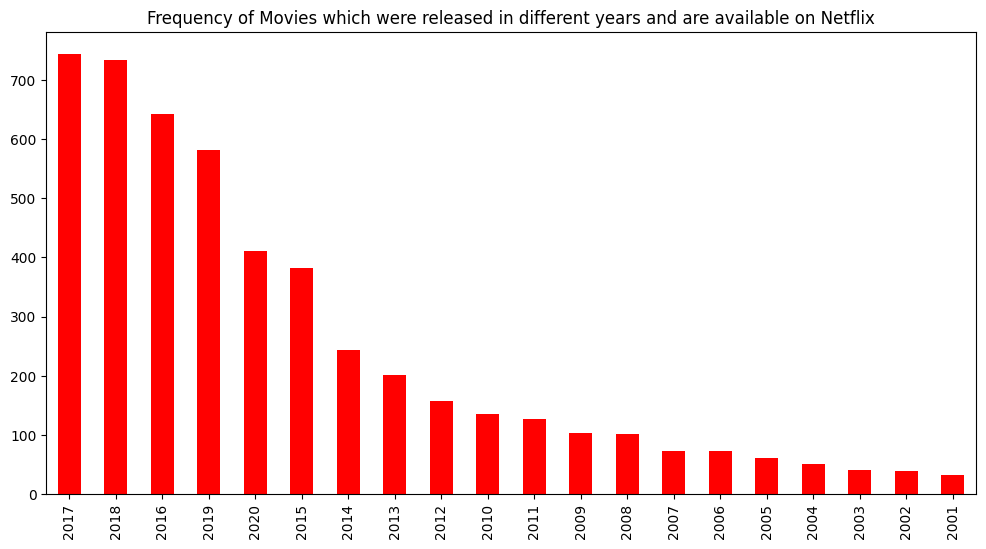

In [43]:
plt.figure(figsize=(12,6))
df[df["type"]=="Movie"]["release_year"].value_counts()[:20].plot(kind="bar",color="Red")
plt.title("Frequency of Movies which were released in different years and are available on Netflix")

Text(0.5, 1.0, 'Frequency of TV shows which were released in different years and are available on Netflix')

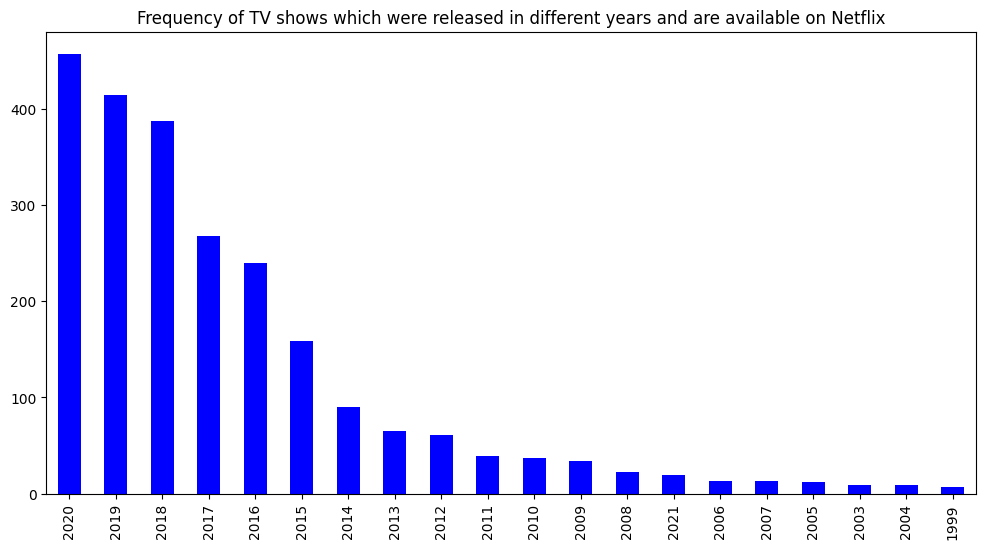

In [44]:
plt.figure(figsize=(12,6))
df[df["type"]=="TV Show"]["release_year"].value_counts()[:20].plot(kind="bar",color="Blue")
plt.title("Frequency of TV shows which were released in different years and are available on Netflix")

Text(0.5, 1.0, 'Top 10 Genres of Movies')

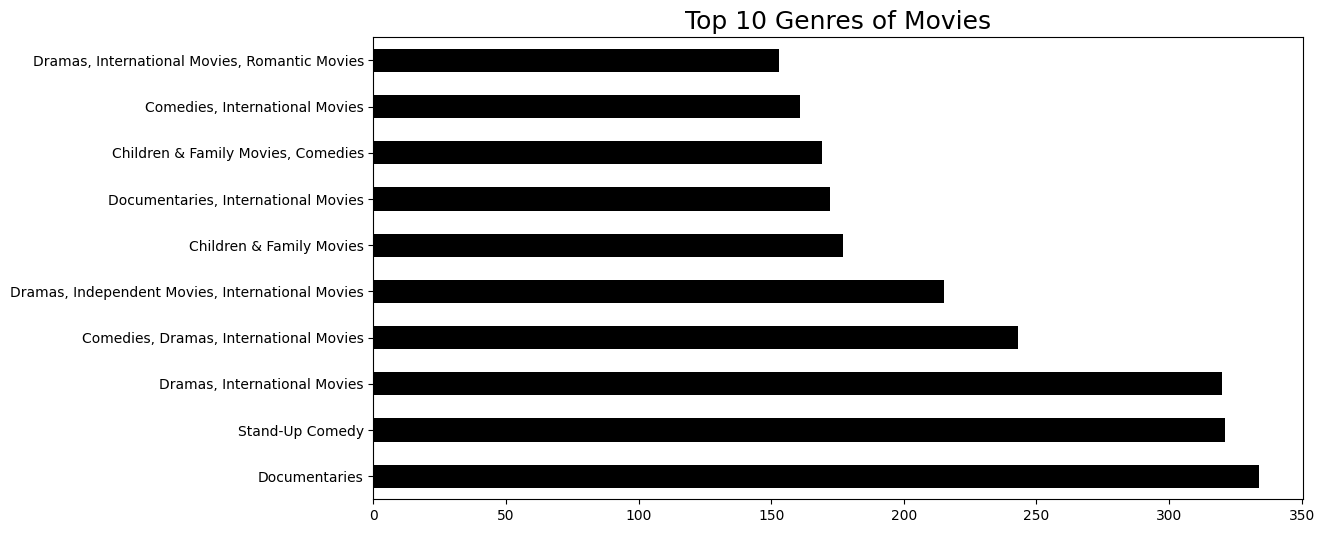

In [45]:
plt.figure(figsize=(12,6))
df[df["type"]=="Movie"]["listed_in"].value_counts()[:10].plot(kind="barh",color="black")
plt.title("Top 10 Genres of Movies",size=18)

Text(0.5, 1.0, 'Top 10 Genres of TV Shows')

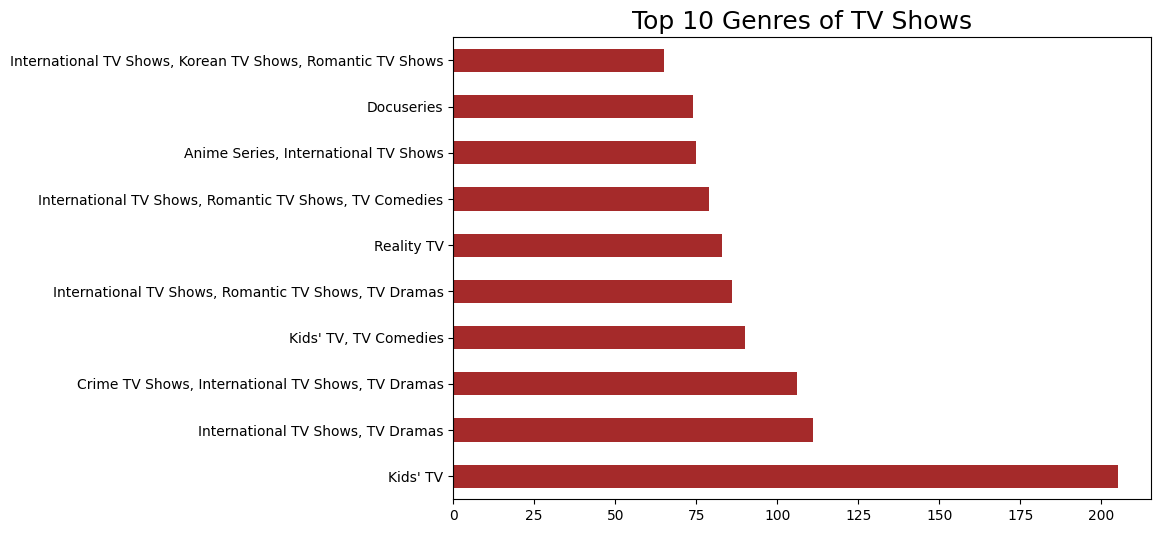

In [49]:
plt.figure(figsize=(9,6))
df[df["type"]=="TV Show"]["listed_in"].value_counts()[:10].plot(kind="barh",color="brown")
plt.title("Top 10 Genres of TV Shows",size=18)

#WordCloud

In [50]:
from wordcloud import WordCloud

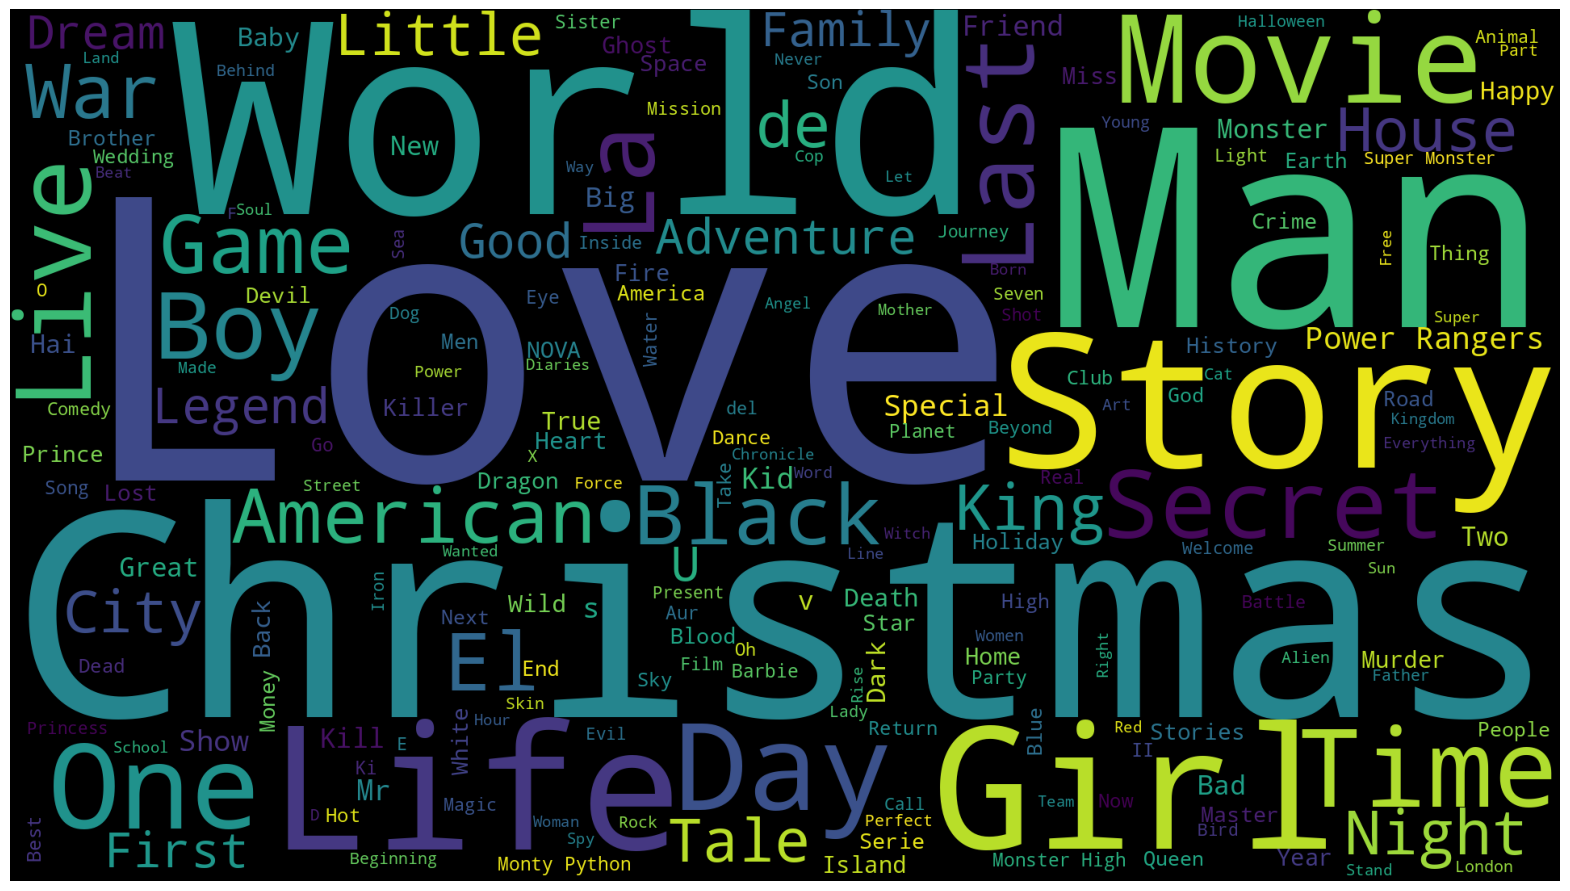

In [53]:
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(background_color='Black',width=1920,height=1080).generate(" ".join(df.title))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('cast.png')
plt.show()

#Country

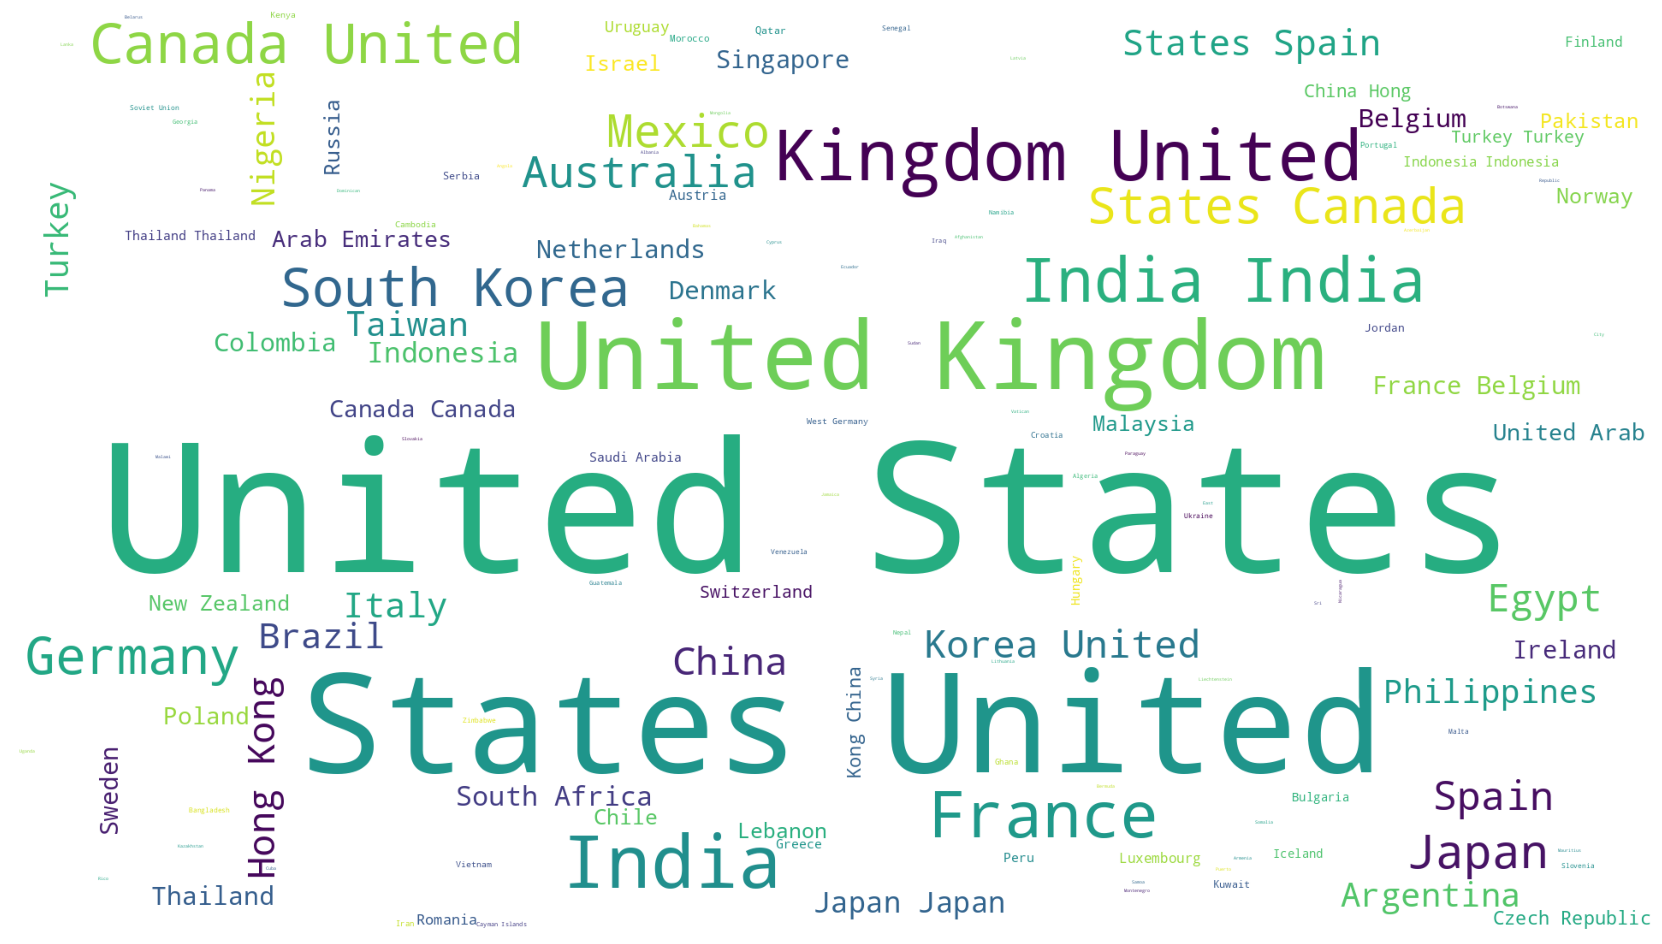

In [58]:
plt.subplots(figsize=(22,12))
wordcloud = WordCloud(background_color='white',width=1920,height=1080).generate(" ".join(df.country))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('country.png')
plt.show()

#Data Prepreation (nlp data)

description

In [68]:
df.columns

Index(['show_id', 'type', 'title', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'relevant'],
      dtype='object')

In [69]:
df.description.iloc[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [70]:
First_des = df.description.iloc[0]
First_des

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

 Importing necessary libraries

In [71]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

Downloading nltk

In [72]:
import nltk 
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> 1


    Error loading 1: Package '1' not found in index



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat.

True